In [4]:
import re
from typing import List
import string
from collections import Counter
import numpy as np
import pandas as pd

from read_data import read_data
from preprocess import (lemmatize_text, number_to_text, remove_accents, 
                        remove_equations, stem_text, remove_website_links, 
                        remove_punctuation, to_lowercase, tokenize_and_remove_stopwords
)
import unicodedata
import inflect

import nltk
#import backend.helpers.install_nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences 
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses


%matplotlib inline

In [6]:
train, test = read_data()

/Users/guldenizbektas/Documents/turknet/notebooks/read_data.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train = pd.read_sql_query("SELECT * FROM train;", conn)
/Users/guldenizbektas/Documents/turknet/notebooks/read_data.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql_query("SELECT * FROM test;", conn)


In [43]:
from sklearn.metrics import confusion_matrix

def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['AI', 'CV', 'DS', "ML"]
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [3]:
def preprocess_text(text):
    # Apply each preprocessing step sequentially
    text = to_lowercase(text)
    text = remove_website_links(text)
    text = remove_equations(text)
    text = remove_punctuation(text)
    text = remove_accents(text)
    text = tokenize_and_remove_stopwords(text)
    text = lemmatize_text(text)
    text = number_to_text(text)
    text = stem_text(text)
    return text

In [4]:
# shuffle the data
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

# target will be the numerical value of the class
labeler = LabelEncoder()
train["target"] = labeler.fit_transform(train["category"])
test["target"] = labeler.transform(test["category"])

# make ready for human readable results
mapping = dict(zip(labeler.classes_, range(len(labeler.classes_))))
mapping

{'ai': 0, 'cv': 1, 'ds': 2, 'ml': 3}

In [5]:
train["stemmed_text"] = train.text.apply(preprocess_text)
test["stemmed_text"] = test.text.apply(preprocess_text)

In [6]:
MAX_NB_WORDS = 4000 #5000
MAX_SEQUENCE_LENGTH = 400

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.stemmed_text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

x_train = pad_sequences(tokenizer.texts_to_sequences(train.stemmed_text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.stemmed_text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 20456
Training X Shape: (6000, 400)
Testing X Shape: (2000, 400)


In [8]:
y_train = tf.one_hot(train["target"], depth=len(mapping))
y_test = tf.one_hot(test["target"], depth=len(mapping))

2023-07-20 01:37:23.589441: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-20 01:37:23.589460: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-20 01:37:23.589467: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-20 01:37:23.589501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-20 01:37:23.589519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(vocab_size,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,"relu",name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,"softmax")(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model


In [30]:
model = RNN()
model.summary()
metric = tf.metrics.F1Score()
opt = tf.keras.optimizers.legacy.Adam()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy', metric])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 400)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 400, 50)           1022800   
                                                                 
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 1069908 (4.08 MB)
Trainable params: 1069908 (

In [32]:
model.fit(x_train, y_train, batch_size=128,epochs=10)

Epoch 1/10


2023-07-20 00:57:53.384873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 00:57:53.659279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 00:57:54.274021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 12s 215ms/step - loss: 1.2180 - accuracy: 0.4080 - f1_score: 0.3499
Epoch 2/10
47/47 [==============================] - 12s 256ms/step - loss: 0.6484 - accuracy: 0.7482 - f1_score: 0.7414
Epoch 3/10
47/47 [==============================] - 12s 253ms/step - loss: 0.2935 - accuracy: 0.9023 - f1_score: 0.9027
Epoch 4/10
47/47 [==============================] - 10s 207ms/step - loss: 0.1538 - accuracy: 0.9548 - f1_score: 0.9549
Epoch 5/10
47/47 [==============================] - 9s 199ms/step - loss: 0.0769 - accuracy: 0.9815 - f1_score: 0.9815
Epoch 6/10
47/47 [==============================] - 9s 201ms/step - loss: 0.0444 - accuracy: 0.9907 - f1_score: 0.9907
Epoch 7/10
47/47 [==============================] - 9s 187ms/step - loss: 0.0263 - accuracy: 0.9942 - f1_score: 0.9942
Epoch 8/10
47/47 [==============================] - 9s 183ms/step - loss: 0.0219 - accuracy: 0.9952 - f1_score: 0.9952
Epoch 9/10
47/47 [==============================] - 8s 

In [33]:
model.evaluate(x_test, y_test)

2023-07-20 00:59:50.425824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 00:59:50.503623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 31ms/step - loss: 0.5816 - accuracy: 0.8705 - f1_score: 0.8705


[0.5816466808319092,
 0.8705000281333923,
 array([0.86252356, 0.9198397 , 0.8577586 , 0.84189725], dtype=float32)]

It was going well but our model overfitted 🫠 That's not good. Let's increase `embedding_dim`.

In [37]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(vocab_size,200,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,"relu",name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,"softmax")(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
metric = tf.metrics.F1Score()
opt = tf.keras.optimizers.legacy.Adam()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy', metric])

model.fit(x_train, y_train, batch_size=128,epochs=6)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 400)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 400, 200)          4091200   
                                                                 
 lstm_8 (LSTM)               (None, 64)                67840     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4176708 (15.93 MB)
Trainable params: 4176708 

2023-07-20 01:06:03.674174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 01:06:03.862498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 01:06:04.206033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 18s 368ms/step - loss: 1.3448 - accuracy: 0.4985 - f1_score: 0.4904
Epoch 2/6
47/47 [==============================] - 16s 331ms/step - loss: 0.6469 - accuracy: 0.7635 - f1_score: 0.7616
Epoch 3/6
47/47 [==============================] - 16s 329ms/step - loss: 0.2639 - accuracy: 0.9160 - f1_score: 0.9161
Epoch 4/6
47/47 [==============================] - 14s 291ms/step - loss: 0.1228 - accuracy: 0.9665 - f1_score: 0.9665
Epoch 5/6
47/47 [==============================] - 13s 276ms/step - loss: 0.0609 - accuracy: 0.9858 - f1_score: 0.9858
Epoch 6/6
47/47 [==============================] - 12s 257ms/step - loss: 0.0411 - accuracy: 0.9892 - f1_score: 0.9892


In [38]:
model.evaluate(x_test, y_test)

2023-07-20 01:07:32.519416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 01:07:32.611087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 34ms/step - loss: 0.5467 - accuracy: 0.8675 - f1_score: 0.8678


[0.546737015247345,
 0.8675000071525574,
 array([0.8654038 , 0.88125   , 0.88778555, 0.83689314], dtype=float32)]

First thing comming to my mind is that this network a bit big for it? We dont have much data so our network learns the training set so well but has lack on test set. We need to change our network maybe.

In [9]:
def model3():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(vocab_size,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,"relu",name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,"softmax")(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = model3()
model.summary()
metric = tf.metrics.F1Score()
opt = tf.keras.optimizers.legacy.Adam()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy', metric])

model.fit(x_train, y_train, batch_size=128,epochs=6)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 400)]             0         
                                                                 
 embedding (Embedding)       (None, 400, 50)           1022800   
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 1069908 (4.08 MB)
Trainable params: 1069908 (4.

2023-07-20 01:37:43.739636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 01:37:43.924746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 01:37:44.187454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 10s 181ms/step - loss: 1.2661 - accuracy: 0.4275 - f1_score: 0.4299
Epoch 2/6
47/47 [==============================] - 10s 216ms/step - loss: 0.7187 - accuracy: 0.7380 - f1_score: 0.7365
Epoch 3/6
47/47 [==============================] - 9s 199ms/step - loss: 0.3457 - accuracy: 0.8895 - f1_score: 0.8890
Epoch 4/6
47/47 [==============================] - 11s 243ms/step - loss: 0.1584 - accuracy: 0.9515 - f1_score: 0.9514
Epoch 5/6
47/47 [==============================] - 11s 230ms/step - loss: 0.0954 - accuracy: 0.9760 - f1_score: 0.9760
Epoch 6/6
47/47 [==============================] - 10s 205ms/step - loss: 0.0488 - accuracy: 0.9878 - f1_score: 0.9878


In [10]:
model.evaluate(x_test, y_test)

2023-07-20 01:38:50.996632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 01:38:51.073396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 29ms/step - loss: 0.4224 - accuracy: 0.8675 - f1_score: 0.8670


[0.42235538363456726,
 0.8675000071525574,
 array([0.88610035, 0.87021476, 0.8804233 , 0.8312236 ], dtype=float32)]

Still overfitting. Okay. Trying another basic network on Kaggle because it was so slow in my local i don't understand why. Just one thing because of nltk wordnet I couldn't make it to do lemma so I only did stem. It won't make big difference probably.

In [ ]:
model = Sequential()

embedding_dim = 100 
model.add(Embedding(vocab_size, embedding_dim, input_length=MAX_SEQUENCE_LENGTH))

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(4, activation='softmax'))

metric = tf.metrics.CategoricalAccuracy()
opt = tf.keras.optimizers.legacy.Adam()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy', metric])

model.fit(x_train, y_train, batch_size=128,epochs=6)

I trained this network on Kaggle. Still overfitted but at least test set accuracy got increased. I saved the model and the tokenizer.

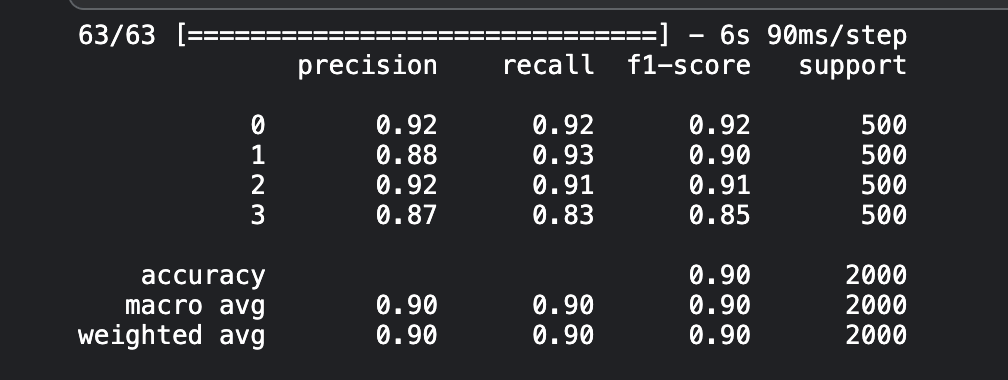

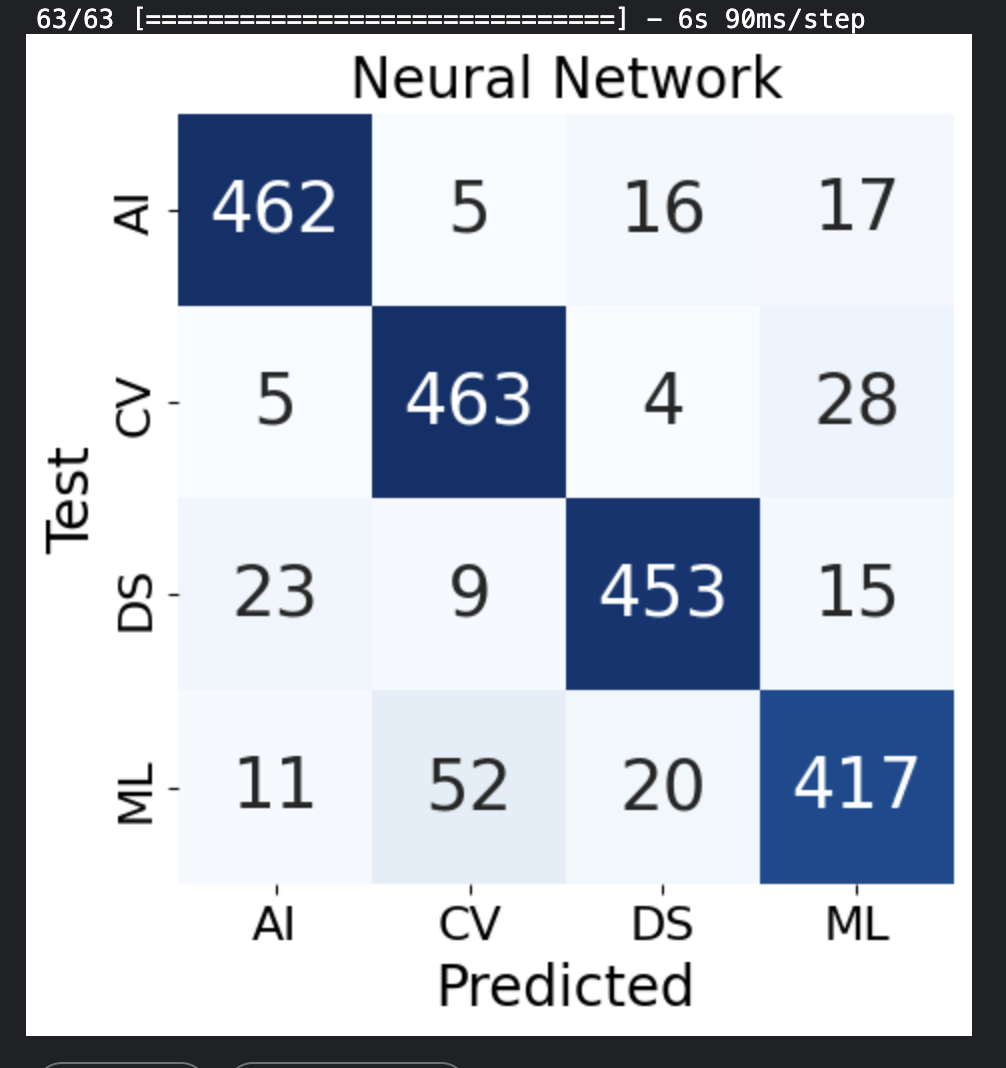

Label 3 always got the least score which is ML. Since it is a broad subject, I think it falls under the category of AI. Generalizing a model category may also be difficult because concepts and topics are close. I definitely would add more ML data to it.

In [ ]:
GLOVE_EMB = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 40

embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

metr = tf.metrics.CategoricalAccuracy()
model.compile(optimizer=Adam(), loss='categorical_crossentropy',
              metrics=['accuracy', metr])

# Create EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',    # Metric to monitor for early stopping (e.g., validation loss)
    patience=5
)

# Create ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model',   # Filepath to save the best model
    monitor='val_loss',         # Metric to monitor for saving the best model
    save_best_only=True,        # Save only the best model based on the monitored metric
    save_weights_only=False,    # Save the entire model, including architecture and weights
    verbose=1                   # Verbosity level: 0 (silent), 1 (progress bar), 2 (one line per epoch)
)

y_train = tf.one_hot(train["target"], depth=len(mapping))
y_test = tf.one_hot(test["target"], depth=len(mapping))

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[early_stopping_callback, model_checkpoint_callback])

I trained above code Kaggle. Results are the same. Our data is limited, probably that's why we overfit. I'll share the results in report notebook.

Let's try without stemming like we did in ML algorithms to see it is the same with neural networks to that results are not that different.

In [25]:
def preprocess_text(text):
    # Apply each preprocessing step sequentially
    text = to_lowercase(text)
    text = remove_website_links(text)
    text = remove_equations(text)
    text = remove_punctuation(text)
    text = remove_accents(text)
    text = tokenize_and_remove_stopwords(text)
    text = lemmatize_text(text)
    text = number_to_text(text)
    #text = stem_text(text)
    return text

In [26]:
# shuffle the data
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

# target will be the numerical value of the class
labeler = LabelEncoder()
train["target"] = labeler.fit_transform(train["category"])
test["target"] = labeler.transform(test["category"])

# make ready for human readable results
mapping = dict(zip(labeler.classes_, range(len(labeler.classes_))))
mapping

{'ai': 0, 'cv': 1, 'ds': 2, 'ml': 3}

In [27]:
train["clean_text"] = train.text.apply(preprocess_text)
test["clean_text"] = test.text.apply(preprocess_text)

In [28]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 400

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.clean_text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

x_train = pad_sequences(tokenizer.texts_to_sequences(train.clean_text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.clean_text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 25774
Training X Shape: (6000, 400)
Testing X Shape: (2000, 400)


In [30]:
y_train = tf.one_hot(train["target"], depth=len(mapping))
y_test = tf.one_hot(test["target"], depth=len(mapping))

In [39]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(vocab_size,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,"relu",name='FC1')(layer)
    layer = Dropout(0.6)(layer)
    layer = Dense(128,"relu",name='FC2')(layer)
    layer = Dropout(0.6)(layer)
    layer = Dense(4,"softmax")(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [40]:
model = RNN()
model.summary()
metric = tf.metrics.F1Score()
opt = tf.keras.optimizers.legacy.Adam()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy', metric])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 400)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 400, 50)           1288700   
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 FC2 (Dense)                 (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0   

In [41]:
model.fit(x_train, y_train, batch_size=128,epochs=10)

Epoch 1/10


2023-07-20 13:14:42.142872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 13:14:42.436350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 13:14:42.859270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 12s 220ms/step - loss: 1.2925 - accuracy: 0.4010 - f1_score: 0.3774
Epoch 2/10
47/47 [==============================] - 13s 276ms/step - loss: 0.8002 - accuracy: 0.6512 - f1_score: 0.6377
Epoch 3/10
47/47 [==============================] - 13s 270ms/step - loss: 0.4534 - accuracy: 0.8362 - f1_score: 0.8370
Epoch 4/10
47/47 [==============================] - 12s 261ms/step - loss: 0.2146 - accuracy: 0.9333 - f1_score: 0.9335
Epoch 5/10
47/47 [==============================] - 10s 221ms/step - loss: 0.1075 - accuracy: 0.9727 - f1_score: 0.9727
Epoch 6/10
47/47 [==============================] - 10s 215ms/step - loss: 0.0703 - accuracy: 0.9838 - f1_score: 0.9838
Epoch 7/10
47/47 [==============================] - 9s 200ms/step - loss: 0.0555 - accuracy: 0.9857 - f1_score: 0.9857
Epoch 8/10
47/47 [==============================] - 9s 182ms/step - loss: 0.0395 - accuracy: 0.9900 - f1_score: 0.9900
Epoch 9/10
47/47 [==============================] - 9

In [42]:
model.evaluate(x_test, y_test)

2023-07-20 13:16:26.898349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 13:16:27.024064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 37ms/step - loss: 1.0026 - accuracy: 0.8155 - f1_score: 0.8162


[1.0026212930679321,
 0.815500020980835,
 array([0.7922874 , 0.8818737 , 0.8650964 , 0.72534466], dtype=float32)]

Still overfitting, no difference at all.

63/63 [==============================] - 1s 20ms/step


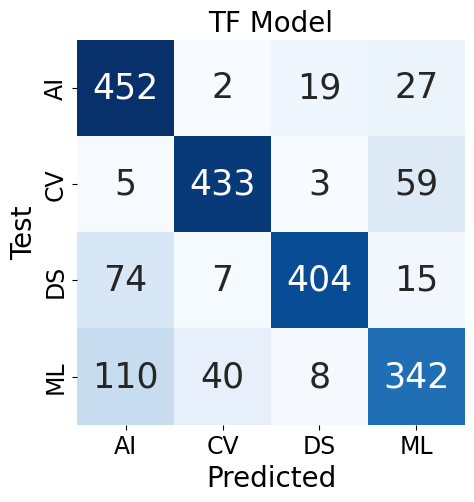

In [45]:
conf_matrix(test["target"], model.predict(x_test).argmax(-1), "TF Model")

In [46]:
print(classification_report(test["target"], model.predict(x_test).argmax(-1)))

63/63 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       500
           1       0.90      0.87      0.88       500
           2       0.93      0.81      0.87       500
           3       0.77      0.68      0.73       500

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



In [49]:
train_ek = test[:1000]
new_train = pd.concat([train, train_ek])

In [50]:
new_test = test[1000:]

In [53]:
new_train = new_train.reset_index(drop=True)
new_test = new_test.reset_index(drop=True)

In [54]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_train.clean_text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

x_train = pad_sequences(tokenizer.texts_to_sequences(new_train.clean_text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(new_test.clean_text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 28233
Training X Shape: (7000, 400)
Testing X Shape: (1000, 400)


In [55]:
y_train = tf.one_hot(new_train["target"], depth=len(mapping))
y_test = tf.one_hot(new_test["target"], depth=len(mapping))

In [97]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(vocab_size,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(32)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = Dense(128,"relu",name='FC1')(layer)
    layer = Dropout(0.6)(layer)
    layer = Dense(4,"softmax")(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
metric = tf.metrics.F1Score()
opt = tf.keras.optimizers.legacy.Adam()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy', metric])

model.fit(x_train, y_train, batch_size=256,epochs=5)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 400)]             0         
                                                                 
 embedding_14 (Embedding)    (None, 400, 50)           1411650   
                                                                 
 lstm_14 (LSTM)              (None, 32)                10624     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 FC1 (Dense)                 (None, 128)               4224      
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                          

2023-07-20 14:59:03.168383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 14:59:03.630672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 14:59:05.156032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 418ms/step - loss: 1.2699 - accuracy: 0.4024 - f1_score: 0.3957
Epoch 2/5
28/28 [==============================] - 17s 592ms/step - loss: 0.6783 - accuracy: 0.7224 - f1_score: 0.7132
Epoch 3/5
28/28 [==============================] - 19s 687ms/step - loss: 0.3030 - accuracy: 0.8944 - f1_score: 0.8941
Epoch 4/5
28/28 [==============================] - 19s 672ms/step - loss: 0.1351 - accuracy: 0.9604 - f1_score: 0.9605
Epoch 5/5
28/28 [==============================] - 19s 662ms/step - loss: 0.0590 - accuracy: 0.9843 - f1_score: 0.9843


In [98]:
model.evaluate(x_test, y_test)

2023-07-20 15:00:36.503197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 15:00:36.731506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 90ms/step - loss: 0.8507 - accuracy: 0.7900 - f1_score: 0.7920


[0.8507104516029358,
 0.7900000214576721,
 array([0.78846145, 0.8363636 , 0.75905514, 0.78414094], dtype=float32)]

In [99]:
print(classification_report(new_test["target"], model.predict(x_test).argmax(-1)))

2023-07-20 15:01:38.329648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-20 15:01:38.618680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

           0       0.91      0.69      0.79       236
           1       0.88      0.80      0.84       259
           2       0.62      0.98      0.76       245
           3       0.92      0.68      0.78       260

    accuracy                           0.79      1000
   macro avg       0.83      0.79      0.79      1000
weighted avg       0.83      0.79      0.79      1000



32/32 [==============================] - 1s 32ms/step


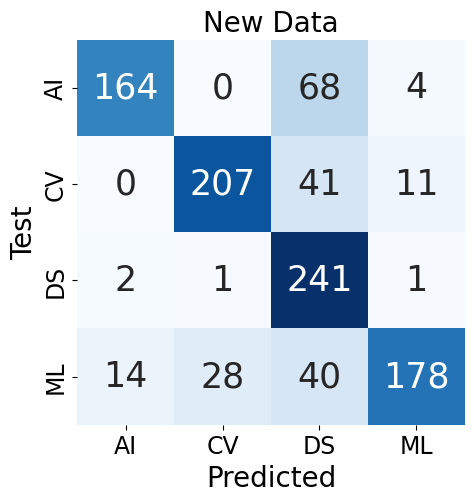

In [100]:
conf_matrix(new_test["target"], model.predict(x_test).argmax(-1), "New Data")

In [101]:
txt = "We introduce a new class of objectives for optimal transport computations of datasets in high-dimensional Euclidean spaces. The new objectives are parametrized by ρ≥1, and provide a metric space ρ(⋅,⋅) for discrete probability distributions in ℝd. As ρ approaches 1, the metric approaches the Earth Mover's distance, but for ρ larger than (but close to) 1, admits significantly faster algorithms. Namely, for distributions μ and ν supported on n and m vectors in ℝd of norm at most r and any ϵ>0, we give an algorithm which outputs an additive ϵr-approximation to ρ(μ,ν) in time (n+m)⋅poly((nm)(ρ−1)/ρ⋅2ρ/(ρ−1)/ϵ)."

txt = preprocess_text(txt)
# Convert the preprocessed text to sequences using the existing tokenizer
sequences = tokenizer.texts_to_sequences([txt])

# Pad the sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded_sequences)
pred

1/1 [==============================] - 0s 430ms/step


array([[0.15706691, 0.1717302 , 0.5218921 , 0.14931077]], dtype=float32)

In [102]:
pred.argmax(-1)

array([2])

In [90]:
mapping

{'ai': 0, 'cv': 1, 'ds': 2, 'ml': 3}